In [1]:
import numpy as np
import scipy as sp
import scipy.integrate as spint

import matplotlib.pyplot as plt

In [2]:
class SolutionBranch():
    
    def __init__(self, sol, stage):
        if type(sol) is list:
            self.sols = sol
            self.stages = stage
        else:
            self.sols = [sol]
            self.stages = [stage]
        self.DOF = self.sols[0].y.shape[0] # get size of the state
        
    def sol(self, time):
        
        time = np.asarray(time)
        if time.ndim == 0:
            return self._sol(time)
        
        ys = [self._sol(t) for t in time]
        
        return np.transpose(np.vstack(ys))
    
    def _sol(self, time):
        """Get the solution at some time in this branch. If there are multiple stages, checks the last one first and works backwards"""
        
        # each solution segment has a t min and a t max
        for sol in reversed(self.sols):
            #checks from the back!
            if time >= sol.sol.t_min and time <= sol.sol.t_max:
                return sol.sol(time)
        # if it doesnt fall into any of the ranges, return the error
        error = [np.nan,]*self.DOF
        if error is None:
            raise ValueError("Requested time is not in the solved times")
            
        return error
    
    def t_min(self):
        return min(sol.sol.t_min for sol in self.sols)
    
    def t_max(self):
        return max(sol.sol.t_max for sol in self.sols)
            
    
    
    def __add__(self, other):
        """Add a second branch"""
        
        if self.DOF != other.DOF:
            raise RuntimeError("Adding SolutionBranches requires them to have the same state vector size")
        
        stages = self.stages + other.stages
        sols = self.sols + other.sols
        
        newBranch = SolutionBranch(sols, stages)

        return newBranch
        
    def __repr__(self):
        return f'\n [\n Stages: {self.stages}\n Sols: {self.sols} \n ]\n '
    

In [168]:
class VerySimpleRocket():
    
    def __init__(self):
        self.m = 40
        self.T = 4000
        self.g = 9.81
        self.y0 = np.array([0., 0.])
        self.rhoCDA1 = 0.05
        self.rhoCDA2 = 0.1
        
        self.stage_list = [0,1,2]
        self.staging_functions = [self.staging_apogee,self.staging_deploy_main]
        self.nominal_stages = [0,1,2] # defines this as a nominal flight
        
    def staging_apogee(self,t,y,stage=0):
        return y[1]
    staging_apogee.terminal = False
    staging_apogee.direction=-1
    
    def staging_deploy_main(self, t, y, stage=0):
        return y[0]-1500
    staging_deploy_main.terminal = False
    staging_deploy_main.direction = -1
    
    def nominal_next_stage(self, stage):
        if stage == 0:
            return 1 # if there is a staging event, can branch to any of 1, or 2
        if stage == 1:
            return 2 # if there is a staging event, can only branch to 1 or 2
        if stage == 2:
            return None # can only branch to 2
        
        
        
    def next_stages(self, stage):
        
        if stage == 0:
            return [1,2] # if there is a staging event, can branch to any of 1, or 2
        if stage == 1:
            return [2] # if there is a staging event, can only branch to 1 or 2
        if stage == 2:
            return [] # can only branch to 2
        
    def dynamics(self, t, y, stage=0):

        if stage == 0:
            if t<4:
                return np.array([y[1], self.T/self.m - self.g])
            else:
                return np.array([y[1], -self.g])
                
        elif stage == 1:
            return np.array([y[1], -0.5*self.rhoCDA1*y[1]*abs(y[1])/self.m - self.g])
        
        elif stage == 2:
            return np.array([y[1], -0.5*self.rhoCDA2*y[1]*abs(y[1])/self.m - self.g])
        
        else:
            raise ValueError

class Sim():
    def __init__(self, rocket):
        
        self.rocket = rocket
        self.t_span = (0,10000)
        self.sols = []
        
        
    def landing(self, t, y, stage=0):
        return y[0]+0.1
    landing.terminal = True
    landing.direction = -1
        
    def solve(self, t_span, y0, stage, user_events=[]):

        sol = spint.solve_ivp(self.rocket.dynamics, t_span, y0, args=(stage,), events=user_events + [self.landing], dense_output=True)
        
        assert sol.status==1, "Did not terminate, probably need to increase t_span"
        
        return SolutionBranch(sol, stage)
    
    def get_staging_times_states(self,sol, t_span):
        ts = []
        ys = []
        for sol in sol.sols:
            for i in range(len(sol.t_events)):
                if not sol.t_events[i] in t_span:
                    ts.extend(sol.t_events[i])
                    ys.extend(sol.y_events[i])
        return ts, ys
    
    
    def nominal_solve(self, t_span, y0, starting_stage):
        
        # simulate this stage
        print(f'\n Nominal Simulating: T: {t_span}, Y0: {y0}, Stage: {starting_stage}')
        
        sol = self.solve(t_span, y0, starting_stage, self.rocket.staging_functions)
        
        # get the flattened list of t events
        ts, ys = self.get_staging_times_states(sol, t_span)
        
        print(f'Current ts: {ts}')
        
        # if there are no events except the landing, return the sol
        if len(ts) == 1: # only landing case left
            print("No further cases. Returning")
            return sol
        
        # else, take the smallest, and generate a new list of sims, as long as it isnt the start time
        (new_t,i) = min((t,i) for i,t in enumerate(ts))
    
        # figure out the next phase
        new_stage = self.rocket.nominal_next_stage(starting_stage)
        new_tspan = [new_t, t_span[-1]]
        new_y0 = ys[i]
        
        return sol + self.nominal_solve(new_tspan, new_y0, new_stage)
        
    
    def full_solve(self, t_span, y0, starting_stage):
        
        # simulate this stage
        print(f'\n Full Simulating: T: {t_span}, Y0: {y0}, Stage: {starting_stage}')
        
        sol = self.solve(t_span, y0, starting_stage, self.rocket.staging_functions)
        
        # get the flattened list of t events
        ts, ys = self.get_staging_times_states(sol)
        
        print(f'Current ts: {ts}')
        
        # if there are no events except the landing, return the sol
        if len(ts) ==1: # only landing case left
            print("No further cases. Returning")
            return [sol]
        
        # else, take the smallest, and generate a new list of sims
        (new_t,i) = min((t,i) for i,t in enumerate(ts))
    
        
        # loop over all the branching times
        new_sols = [sol]
        for i in range(len(ts)-1):

            new_tspan = [ts[i], t_span[-1]]
            new_y0 = ys[i]
            print(f'There are further splits, using new tspan = {new_tspan}, at y0={new_y0}')

            # loop over each of the new stages, get the new sol
            for new_stage in self.rocket.next_stages(starting_stage): 
                new_sols.extend([sol + new_sol for new_sol in self.full_solve(new_tspan, new_y0, new_stage)])

        return new_sols

In [169]:
r = VerySimpleRocket()

In [170]:
s = Sim(r)

In [171]:
s

In [172]:
sol=s.solve([0,600], r.y0, 0, user_events=r.staging_functions)

In [173]:
sol.sols[0]

  message: 'A termination event occurred.'
     nfev: 98
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x11e8a9978>
   status: 1
  success: True
        t: array([0.00000000e+00, 1.00000000e-04, 1.10000000e-03, 1.11000000e-02,
       1.11100000e-01, 1.11110000e+00, 2.79214387e+00, 3.62727257e+00,
       4.46240128e+00, 5.31679544e+00, 1.38607371e+01, 8.10614674e+01])
 t_events: [array([41.57554744]), array([76.97762493]), array([81.06146741])]
        y: array([[ 0.00000000e+00,  4.50950000e-07,  5.45649500e-05,
         5.55615495e-03,  5.56617055e-01,  5.56717261e+01,
         3.51563658e+02,  5.93319709e+02,  8.91394822e+02,
         1.19888202e+03,  3.87988823e+03, -1.00000000e-01],
       [ 0.00000000e+00,  9.01900000e-03,  9.92090000e-02,
         1.00110900e+00,  1.00201090e+01,  1.00210109e+02,
         2.51823455e+02,  3.27143713e+02,  3.64079964e+02,
         3.55698357e+02,  2.71882290e+02, -3.87356875e+02]])
 y_events: [array([[7647

In [174]:
sol.t_max()

81.06146740852928

In [175]:
sol2=s.solve([1,600], 2*r.y0, 0, user_events=r.staging_functions)

In [176]:
sol2.sols[0]

  message: 'A termination event occurred.'
     nfev: 110
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x11e8f34e0>
   status: 1
  success: True
        t: array([ 1.        ,  1.0001    ,  1.0011    ,  1.0111    ,  1.1111    ,
        2.1111    ,  3.25509584,  3.7997873 ,  4.34447875,  4.92078154,
       10.68380937, 62.49560271])
 t_events: [array([32.54055889]), array([56.8607946]), array([62.49560271])]
        y: array([[ 0.00000000e+00,  4.50950000e-07,  5.45649500e-05,
         5.55615495e-03,  5.56617055e-01,  5.56717261e+01,
         2.29328694e+02,  3.53491088e+02,  5.01611433e+02,
         6.59389754e+02,  2.05797498e+03, -1.00000000e-01],
       [ 0.00000000e+00,  9.01900000e-03,  9.92090000e-02,
         1.00110900e+00,  1.00201090e+01,  1.00210109e+02,
         2.03387094e+02,  2.52512816e+02,  2.76603546e+02,
         2.70950016e+02,  2.14414713e+02, -2.93858980e+02]])
 y_events: [array([[4.40117931e+03, 2.84217094e-14]]), array

In [177]:
sol2


 [
 Stages: [0]
 Sols: [  message: 'A termination event occurred.'
     nfev: 110
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x11e8f34e0>
   status: 1
  success: True
        t: array([ 1.        ,  1.0001    ,  1.0011    ,  1.0111    ,  1.1111    ,
        2.1111    ,  3.25509584,  3.7997873 ,  4.34447875,  4.92078154,
       10.68380937, 62.49560271])
 t_events: [array([32.54055889]), array([56.8607946]), array([62.49560271])]
        y: array([[ 0.00000000e+00,  4.50950000e-07,  5.45649500e-05,
         5.55615495e-03,  5.56617055e-01,  5.56717261e+01,
         2.29328694e+02,  3.53491088e+02,  5.01611433e+02,
         6.59389754e+02,  2.05797498e+03, -1.00000000e-01],
       [ 0.00000000e+00,  9.01900000e-03,  9.92090000e-02,
         1.00110900e+00,  1.00201090e+01,  1.00210109e+02,
         2.03387094e+02,  2.52512816e+02,  2.76603546e+02,
         2.70950016e+02,  2.14414713e+02, -2.93858980e+02]])
 y_events: [array([[4.40117931e+03,

In [178]:
sol


 [
 Stages: [0]
 Sols: [  message: 'A termination event occurred.'
     nfev: 98
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x11e8a9978>
   status: 1
  success: True
        t: array([0.00000000e+00, 1.00000000e-04, 1.10000000e-03, 1.11000000e-02,
       1.11100000e-01, 1.11110000e+00, 2.79214387e+00, 3.62727257e+00,
       4.46240128e+00, 5.31679544e+00, 1.38607371e+01, 8.10614674e+01])
 t_events: [array([41.57554744]), array([76.97762493]), array([81.06146741])]
        y: array([[ 0.00000000e+00,  4.50950000e-07,  5.45649500e-05,
         5.55615495e-03,  5.56617055e-01,  5.56717261e+01,
         3.51563658e+02,  5.93319709e+02,  8.91394822e+02,
         1.19888202e+03,  3.87988823e+03, -1.00000000e-01],
       [ 0.00000000e+00,  9.01900000e-03,  9.92090000e-02,
         1.00110900e+00,  1.00201090e+01,  1.00210109e+02,
         2.51823455e+02,  3.27143713e+02,  3.64079964e+02,
         3.55698357e+02,  2.71882290e+02, -3.87356875e+02]])

In [179]:
sol2


 [
 Stages: [0]
 Sols: [  message: 'A termination event occurred.'
     nfev: 110
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x11e8f34e0>
   status: 1
  success: True
        t: array([ 1.        ,  1.0001    ,  1.0011    ,  1.0111    ,  1.1111    ,
        2.1111    ,  3.25509584,  3.7997873 ,  4.34447875,  4.92078154,
       10.68380937, 62.49560271])
 t_events: [array([32.54055889]), array([56.8607946]), array([62.49560271])]
        y: array([[ 0.00000000e+00,  4.50950000e-07,  5.45649500e-05,
         5.55615495e-03,  5.56617055e-01,  5.56717261e+01,
         2.29328694e+02,  3.53491088e+02,  5.01611433e+02,
         6.59389754e+02,  2.05797498e+03, -1.00000000e-01],
       [ 0.00000000e+00,  9.01900000e-03,  9.92090000e-02,
         1.00110900e+00,  1.00201090e+01,  1.00210109e+02,
         2.03387094e+02,  2.52512816e+02,  2.76603546e+02,
         2.70950016e+02,  2.14414713e+02, -2.93858980e+02]])
 y_events: [array([[4.40117931e+03,

In [180]:
sol3 = sol+sol2

In [181]:
sol3


 [
 Stages: [0, 0]
 Sols: [  message: 'A termination event occurred.'
     nfev: 98
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x11e8a9978>
   status: 1
  success: True
        t: array([0.00000000e+00, 1.00000000e-04, 1.10000000e-03, 1.11000000e-02,
       1.11100000e-01, 1.11110000e+00, 2.79214387e+00, 3.62727257e+00,
       4.46240128e+00, 5.31679544e+00, 1.38607371e+01, 8.10614674e+01])
 t_events: [array([41.57554744]), array([76.97762493]), array([81.06146741])]
        y: array([[ 0.00000000e+00,  4.50950000e-07,  5.45649500e-05,
         5.55615495e-03,  5.56617055e-01,  5.56717261e+01,
         3.51563658e+02,  5.93319709e+02,  8.91394822e+02,
         1.19888202e+03,  3.87988823e+03, -1.00000000e-01],
       [ 0.00000000e+00,  9.01900000e-03,  9.92090000e-02,
         1.00110900e+00,  1.00201090e+01,  1.00210109e+02,
         2.51823455e+02,  3.27143713e+02,  3.64079964e+02,
         3.55698357e+02,  2.71882290e+02, -3.87356875e+02

In [182]:
sol.sol(0)

array([0., 0.])

In [183]:
sol3.sol(0)

array([0., 0.])

In [184]:
sol3.sols[0].t.shape

(12,)

In [185]:
sol3.t_max()

81.06146740852928

In [186]:
t = np.linspace(sol3.t_min(),sol3.t_max(), 50)

In [187]:
t

array([ 0.        ,  1.65431566,  3.30863132,  4.96294698,  6.61726265,
        8.27157831,  9.92589397, 11.58020963, 13.23452529, 14.88884095,
       16.54315661, 18.19747228, 19.85178794, 21.5061036 , 23.16041926,
       24.81473492, 26.46905058, 28.12336624, 29.77768191, 31.43199757,
       33.08631323, 34.74062889, 36.39494455, 38.04926021, 39.70357587,
       41.35789153, 43.0122072 , 44.66652286, 46.32083852, 47.97515418,
       49.62946984, 51.2837855 , 52.93810116, 54.59241683, 56.24673249,
       57.90104815, 59.55536381, 61.20967947, 62.86399513, 64.51831079,
       66.17262646, 67.82694212, 69.48125778, 71.13557344, 72.7898891 ,
       74.44420476, 76.09852042, 77.75283609, 79.40715175, 81.06146741])

In [188]:
sol3.sol(t)

array([[ 0.00000000e+00,  1.93064766e+01,  2.40346365e+02,
         6.70805762e+02,  1.10493451e+03,  1.51221564e+03,
         1.89264915e+03,  2.24623505e+03,  2.57297332e+03,
         2.87286398e+03,  3.14590702e+03,  3.39210243e+03,
         3.61145023e+03,  3.80395042e+03,  3.96960298e+03,
         4.10840792e+03,  4.22036525e+03,  4.30547496e+03,
         4.36373704e+03,  4.39515151e+03,  4.39971837e+03,
         4.37743760e+03,  4.32830921e+03,  4.25233321e+03,
         4.14950958e+03,  4.01983834e+03,  3.86331948e+03,
         3.67995300e+03,  3.46973891e+03,  3.23267719e+03,
         2.96876785e+03,  2.67801090e+03,  2.36040633e+03,
         2.01595414e+03,  1.64465433e+03,  1.24650690e+03,
         8.21511854e+02,  3.69669189e+02,  5.42453506e+03,
         5.06562452e+03,  4.67986635e+03,  4.26726056e+03,
         3.82780716e+03,  3.36150613e+03,  2.86835749e+03,
         2.34836123e+03,  1.80151735e+03,  1.22782585e+03,
         6.27286735e+02, -1.00000000e-01],
       [ 0.00

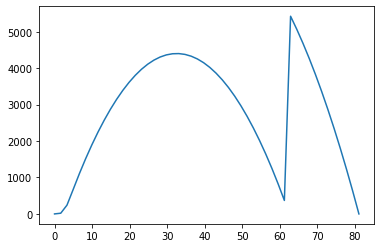

In [189]:
plt.plot(t, sol3.sol(t)[0])

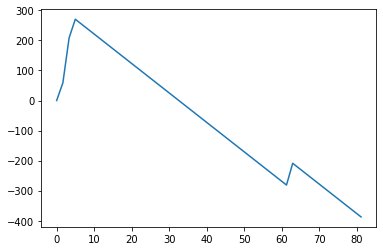

In [190]:
plt.plot(t, sol3.sol(t)[1])

In [191]:
#y1=sol.sol.y_events[0][0]

In [192]:
#y1

In [193]:
#r.staging_functions[1:]

In [194]:
#s.t_span[1]

In [195]:
#r.dynamics(0,y1)

In [196]:
#s.solve([t1, s.t_span[1]], y1, 1, user_events=r.staging_functions[1:]);

In [197]:
# check if the termination is reached
#assert(sol.sol.status==1)

In [202]:
nominal_sol = s.nominal_solve([0,6000], r.y0, 0)


 Nominal Simulating: T: [0, 6000], Y0: [0. 0.], Stage: 0
Current ts: [41.57554744437444, 76.97762493288191, 81.06146740852928]

 Nominal Simulating: T: [41.57554744437444, 6000], Y0: [7647.47127891    0.        ], Stage: 1
Current ts: [99.4907128353565, 111.4657975163297]

 Nominal Simulating: T: [99.4907128353565, 6000], Y0: [1500.         -125.26263141], Stage: 2
Current ts: [114.77337152856462]
No further cases. Returning


/Users/Devansh/.virtualenvs/rocketPy/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


In [206]:
nominal_sol.sol(10)

array([2757.11174051,  309.75612043])

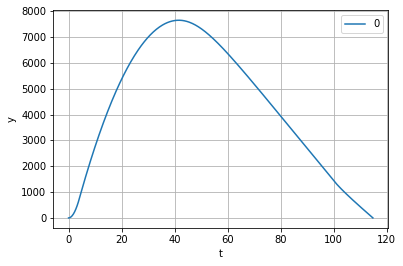

In [211]:
i=0;
t_range = np.linspace(nominal_sol.t_min(),nominal_sol.t_max(), 500)
plt.plot(t_range,nominal_sol.sol(t_range)[0], label=i)

    #plt.xlim([0,50])
plt.grid()
plt.xlabel('t')
plt.ylabel('y')
plt.legend()

In [71]:
sols = s.full_solve([0,6000], r.y0, 0)


 Full Simulating: T: [0, 6000], Y0: [0. 0.], Stage: 0
Current ts: [41.57554744437444, 76.97762493288191, 81.06146740852928]
There are further splits, using new tspan = [41.57554744437444, 6000], at y0=[7647.47127891    0.        ]

 Full Simulating: T: [41.57554744437444, 6000], Y0: [7647.47127891    0.        ], Stage: 1
Current ts: [41.57554744437444, 99.4907128353565, 111.4657975163297]
There are further splits, using new tspan = [99.4907128353565, 6000], at y0=[1500.         -125.26263141]

 Full Simulating: T: [99.4907128353565, 6000], Y0: [1500.         -125.26263141], Stage: 2
Current ts: [99.4907128353565, 114.77337152856462]

 Full Simulating: T: [41.57554744437444, 6000], Y0: [7647.47127891    0.        ], Stage: 2
Current ts: [41.57554744437444, 117.2249566200323, 134.1565857564291]
There are further splits, using new tspan = [117.2249566200323, 6000], at y0=[1500.          -88.57251475]
There are further splits, using new tspan = [76.97762493288191, 6000], at y0=[1500.    

In [72]:
sols

[
  [
  Stages: [0]
  Sols: [  message: 'A termination event occurred.'
      nfev: 98
      njev: 0
       nlu: 0
       sol: <scipy.integrate._ivp.common.OdeSolution object at 0x11ed090f0>
    status: 1
   success: True
         t: array([0.00000000e+00, 1.00000000e-04, 1.10000000e-03, 1.11000000e-02,
        1.11100000e-01, 1.11110000e+00, 2.79214387e+00, 3.62727257e+00,
        4.46240128e+00, 5.31679544e+00, 1.38607371e+01, 8.10614674e+01])
  t_events: [array([41.57554744]), array([76.97762493]), array([81.06146741])]
         y: array([[ 0.00000000e+00,  4.50950000e-07,  5.45649500e-05,
          5.55615495e-03,  5.56617055e-01,  5.56717261e+01,
          3.51563658e+02,  5.93319709e+02,  8.91394822e+02,
          1.19888202e+03,  3.87988823e+03, -1.00000000e-01],
        [ 0.00000000e+00,  9.01900000e-03,  9.92090000e-02,
          1.00110900e+00,  1.00201090e+01,  1.00210109e+02,
          2.51823455e+02,  3.27143713e+02,  3.64079964e+02,
          3.55698357e+02,  2.71882290e+

In [73]:
len(sols)

6

In [ ]:
type(sols[2])

In [ ]:
sols[0]

In [ ]:
f = None
a = 3
(a and f) is None

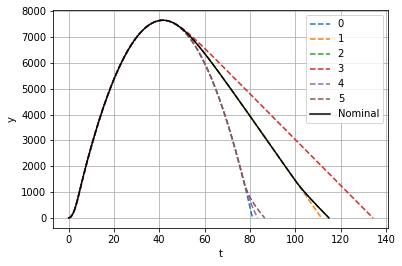

In [219]:
i=0;
for sol in sols:
    t_range = np.linspace(sol.t_min(),sol.t_max(), 500)
    plt.plot(t_range,sol.sol(t_range)[0], '--',label=i)
    i+=1
    #plt.xlim([0,50])
    
t_range = np.linspace(nominal_sol.t_min(),nominal_sol.t_max(), 500)
plt.plot(t_range,nominal_sol.sol(t_range)[0], 'k', label='Nominal')

plt.grid()
plt.xlabel('t')
plt.ylabel('y')
plt.legend()

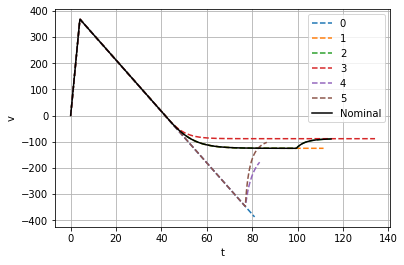

In [220]:
i=0;
for sol in sols:
    t_range = np.linspace(sol.t_min(),sol.t_max(), 500)
    plt.plot(t_range,sol.sol(t_range)[1], '--',label=i)
    i+=1
    #plt.xlim([0,50])
    
t_range = np.linspace(nominal_sol.t_min(),nominal_sol.t_max(), 500)
plt.plot(t_range,nominal_sol.sol(t_range)[1], 'k', label='Nominal')

plt.grid()
plt.xlabel('t')
plt.ylabel('v')
plt.legend()

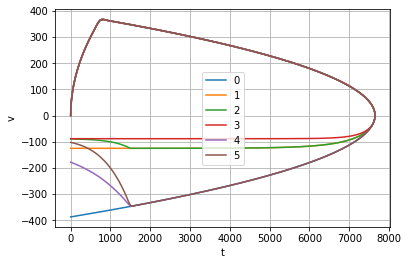

In [209]:
i=0;
for sol in sols:
    t_range = np.linspace(sol.t_min(),sol.t_max(), 500)
    plt.plot(sol.sol(t_range)[0],sol.sol(t_range)[1], label=i)
    i+=1
    #plt.xlim([0,50])
plt.grid()
plt.xlabel('t')
plt.ylabel('v')
plt.legend()

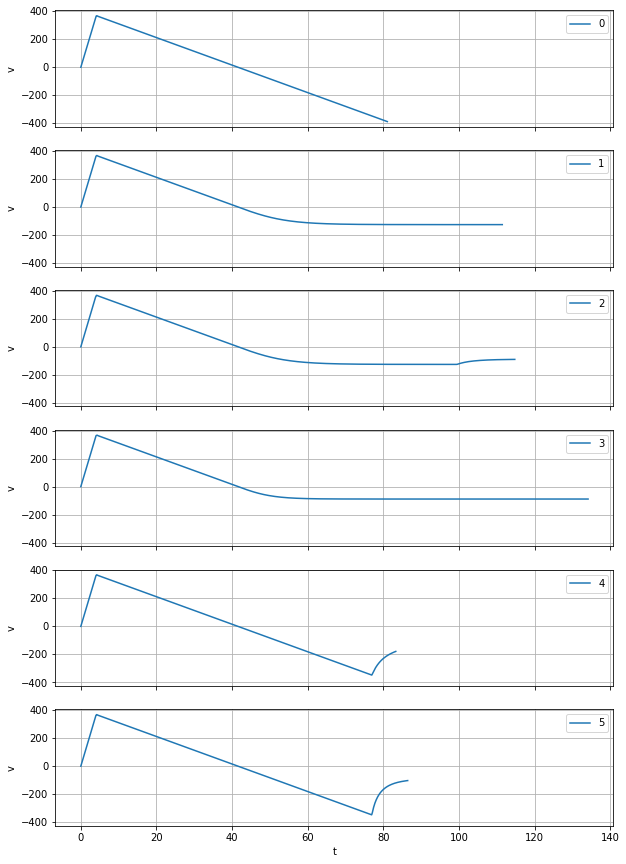

In [210]:
i=0;
fig, axes = plt.subplots(6,1, sharex=True, sharey=True, figsize=(10,15), squeeze=True)
for sol in sols:
    t_range = np.linspace(sol.t_min(),sol.t_max(), 500)
    axes[i].plot(t_range,sol.sol(t_range)[1], label=i)
    
    #plt.xlim([0,50])
    axes[i].grid(True)
    plt.xlabel('t')
    axes[i].set_ylabel('v')
    axes[i].legend()
    i+=1


In [ ]:
n2 = np.array(5)

In [ ]:
n2

In [ ]:
axes

In [ ]:
for s in sols:
    print(s.stages)